# Entropy and related measures

In [34]:
# sphinx_gallery_thumbnail_number = 2
from matplotlib import pyplot as plt
from mne.io import read_raw_eeglab
from pycrostates.cluster import ModKMeans
from pycrostates.datasets import lemon

## Load example data
We load 60 seconds of eyes-closed (EC) resting state data from the [LEMON dataset](https://doi.org/10.1038/sdata.2018.308).

In [35]:
# 010017 (-), 010004 (+), 010005 (-), 010012 (+), 010017 (-), 010019 (-), 010021 (+)
raw_fname = lemon.data_path(subject_id="010021", condition="EC")
raw = read_raw_eeglab(raw_fname, preload=False)
raw.crop(0, 60)  # crop the dataset to speed up computation
raw.load_data()
raw.set_eeg_reference("average")  # Apply a common average reference

/tmp/ipykernel_19437/2164748445.py:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_eeglab(raw_fname, preload=False)
/tmp/ipykernel_19437/2164748445.py:3: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_eeglab(raw_fname, preload=False)


<RawEEGLAB | sub-010021_EC.fdt, 61 x 15001 (60.0 s), ~7.1 MB, data loaded>

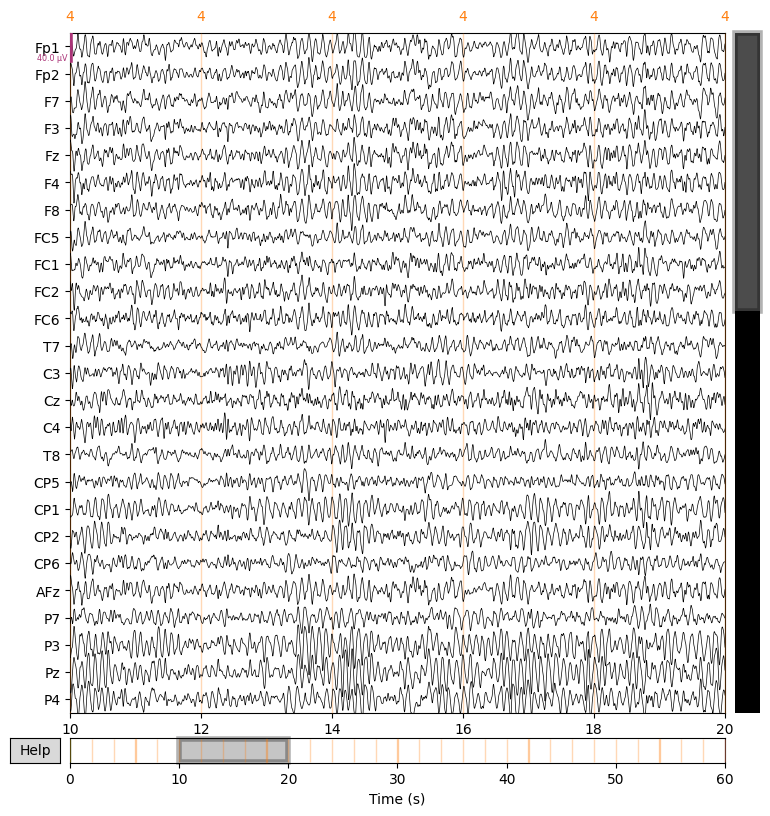

In [41]:
# this subject has a posterior dominant rhythm in the alpha frequency band
_ = raw.plot(duration=10.0, start=10.0, n_channels=25)

## Microstate clustering
Perform a clustering into K=5 microstate classes

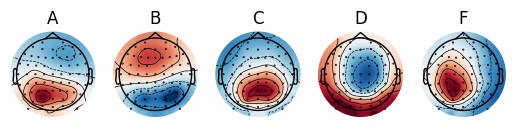

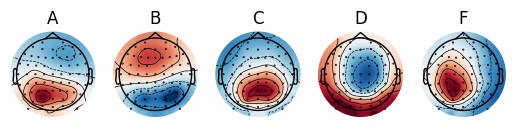

In [42]:
ModK = ModKMeans(n_clusters=5, random_state=42)
ModK.fit(raw, n_jobs=2)
ModK.reorder_clusters(order=[4, 2, 0, 3, 1]) # 010021
ModK.rename_clusters(new_names=["A", "B", "C", "D", "F"])
ModK.plot()

## Segmentation
Perform two segmentations, i.e. back-fitting the maps obtained in the previous step, followed by:
1. Minimal post-processing (`half_window_size=1`, `min_segment_length=1`)
2. Smoothing  (`half_window_size=3`, `min_segment_length=5`)

In [43]:
# Once a set of cluster centers has been fitted, It can be used to predict the
# microstate segmentation with the method
# :meth:`pycrostates.cluster.ModKMeans.predict`. It returns either a
# `~pycrostates.segmentation.RawSegmentation` or an
# `~pycrostates.segmentation.EpochsSegmentation` depending on the object to
# segment. Below, the provided instance is a continuous `~mne.io.Raw` object:

# original:
#half_window_size=10
#min_segment_length=5

segm_pure = ModK.predict(
    raw,
    reject_by_annotation=True,
    factor=10,
    half_window_size=1,
    min_segment_length=1,
    reject_edges=True,
)

segm_smooth = ModK.predict(
    raw,
    reject_by_annotation=True,
    factor=10,
    half_window_size=5,
    min_segment_length=5,
    reject_edges=True,
)

The differences between the non-smoothed (pure) and smoothed microstate sequences can be visualized with the plot method of the segmentation objects.

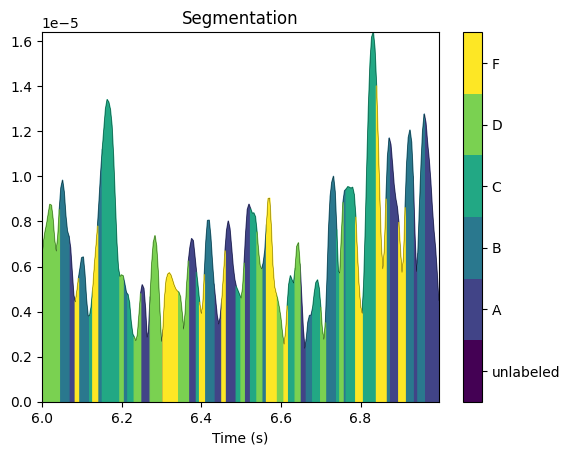

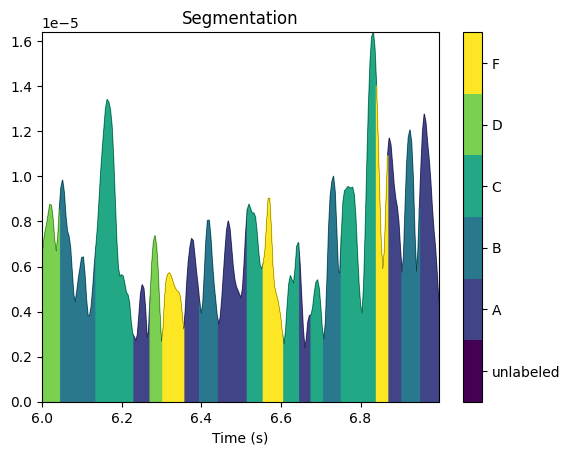

In [44]:
t0, t1 = 6, 7
_ = segm_pure.plot(tmin=t0, tmax=t1)
plt.show()
_ = segm_smooth.plot(tmin=t0, tmax=t1)
plt.show()

## Shannon entropy
The Shannon entropy of the microstate sequence describes how flat the microstate class distribution is. The two extremes are:
1. A flat distribution. In this example, the maximum entropy would be observed if each microstate class (A, B, C, D, F) had probability $p=1/5$. The resulting Shannon entropy would be h=log(5)=2.32 bits.
2. A peaked distribution. If any microstate class occurs with probability $p=1$, and all other classes with probability $p=0$, the resulting Shannon entropy would achieve its minimum value of h=0 bits.  

In the example below, we observe that smoothing leads to a slight entropy reduction. 

In [45]:
# Entropy
# TODO: explain the concept of entropy and its application to MS analysis
h_pure = segm_pure.entropy(ignore_repetitions=False)
h_smooth = segm_smooth.entropy(ignore_repetitions=False)
print(f"Microstate sequence without smoothing, Shannon entropy h = {h_pure:.2f} bits")
print(f"Microstate sequence with    smoothing, Shannon entropy h = {h_smooth:.2f} bits")

Microstate sequence without smoothing, Shannon entropy h = 2.30 bits
Microstate sequence with    smoothing, Shannon entropy h = 2.26 bits


## Entropy rate and excess entropy
The entropy rate of the microstate sequence is a measure of its Kolmogorov complexity, excess entropy measures statistical complexity. High entropy rate (or high Kolmogorov complexity) means the next microstate label is less predictable, based on the sequence history.  
History length is provided as a free parameter `history_length` when calling the function `excess_entropy_rate`, and is given in units of samples.  
The function `excess_entropy_rate` performs a linear fit to joint entropy values across different history lengths and returns two parameters; the slope parameter corresponds to the entropy rate, the y-axis intersection to excess entropy.  
This procedure is illustrated below. Further details are given in [https://doi.org/10.1007/s10548-023-01006-2](https://doi.org/10.1007/s10548-023-01006-2).

Entropy rate: 1.036 bits/sample.
Excess entropy: 1.428 bits.


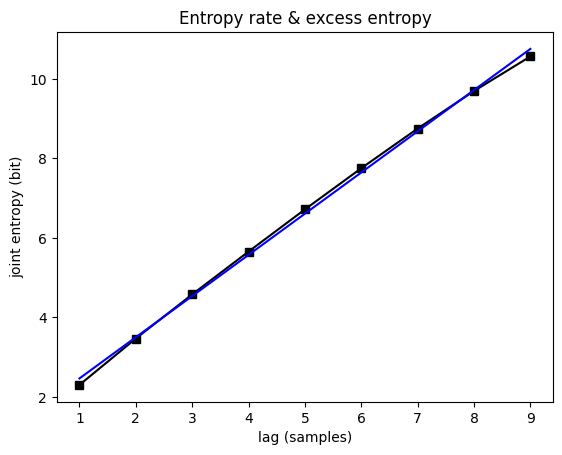

In [46]:
# Excess entropy
# TODO: explain the concept of excess entropy and its application to MS analysis and parameters.
from pycrostates.segmentation import excess_entropy_rate
import matplotlib.pyplot as plt

h_length = 9 # history_length
a, b, residuals, lags, joint_entropies = excess_entropy_rate(segm_pure, 
                                                             history_length=h_length, 
                                                             ignore_repetitions=False)
print(f"Entropy rate: {a:.3f} bits/sample.")
print(f"Excess entropy: {b:.3f} bits.")

# joint entropy plot from which excess entropy and entropy rate are calculated
plt.figure()
plt.plot(lags, joint_entropies, '-sk')
plt.plot(lags, a*lags+b, '-b')
plt.xlabel("lag (samples)")
plt.ylabel("joint entropy (bit)")
plt.title("Entropy rate & excess entropy")
plt.show()

We can now test how microstate sequence (Kolmogorov) complexity changes with pre-processing:
1. no smoothing, full microstate sequence (duplicates not removed)
2. smoothing, full microstate sequence (duplicates not removed)
3. no smoothing, microstate jump sequence (duplicates removed)
4. smoothing, microstate jump sequence (duplicates removed)

Smoothing makes microstate sequences more predictable (less complex), removing duplicates makes sequences less predictable (more complex).

In [47]:
# We can also ignore state repetitions (i.e. self-transitions) by setting the ignore_repetitions to True.
# This is useful when you don't want to take state duration into account.
er_pure, _, _, _, _ = excess_entropy_rate(segm_pure, history_length=h_length, ignore_repetitions=False)
er_smooth, _, _, _, _ = excess_entropy_rate(segm_smooth, history_length=h_length, ignore_repetitions=False)
er_pure_jump, _, _, _, _ = excess_entropy_rate(segm_pure, history_length=h_length, ignore_repetitions=True)
er_smooth_jump, _, _, _, _ = excess_entropy_rate(segm_smooth, history_length=h_length, ignore_repetitions=True)
print(f"1. Microstate      sequence without smoothing, entropy rate: {er_pure:.2f} bits/sample")
print(f"2. Microstate      sequence with    smoothing, entropy rate: {er_smooth:.2f} bits/sample")
print(f"3. Microstate jump sequence without smoothing, entropy rate: {er_pure_jump:.2f} bits/sample")
print(f"4. Microstate jump sequence with    smoothing, entropy rate: {er_smooth_jump:.2f} bits/sample")

1. Microstate      sequence without smoothing, entropy rate: 1.04 bits/sample
2. Microstate      sequence with    smoothing, entropy rate: 0.43 bits/sample
3. Microstate jump sequence without smoothing, entropy rate: 1.20 bits/sample
4. Microstate jump sequence with    smoothing, entropy rate: 0.93 bits/sample


## Autoinformation function
The autoinformation function (AIF) is the information-theoretic analogy to the autocorrelation function (ACF) for numerical time series.  
The autoinformation coefficient at time lag $k$ is the information shared between microstate labels $k$ time samples apart. Mathematically, it is computed as the mutual information between the microstate label $X_t$ at time $t$, and the label $X_{t+k}$ at $t+k$, averaged across the whole sequence: $H(X_{t+k}) - H(X_{t+k} \vert X_{t})$.

Below, we compare the AIF of microstate sequences with and without smoothing. Smoothing increases overall temporal dependencies and removes microstate oscillations (AIF peaks at 50, 100, 150 ms) that are visible in the minimally pre-processed sequence.

In [48]:
# auto_information_function
# TODO: explain the auto_information_function and parameters.
# We compute the AIF for the full microstate sequence with and without smoothing
from pycrostates.segmentation import auto_information_function
import numpy as np

lags1 = np.arange(1, 100)
lags, ai_pure = auto_information_function(segm_pure, lags=lags1, ignore_repetitions=False, n_jobs=2)
lags, ai_smooth = auto_information_function(segm_smooth, lags=lags1, ignore_repetitions=False, n_jobs=2)

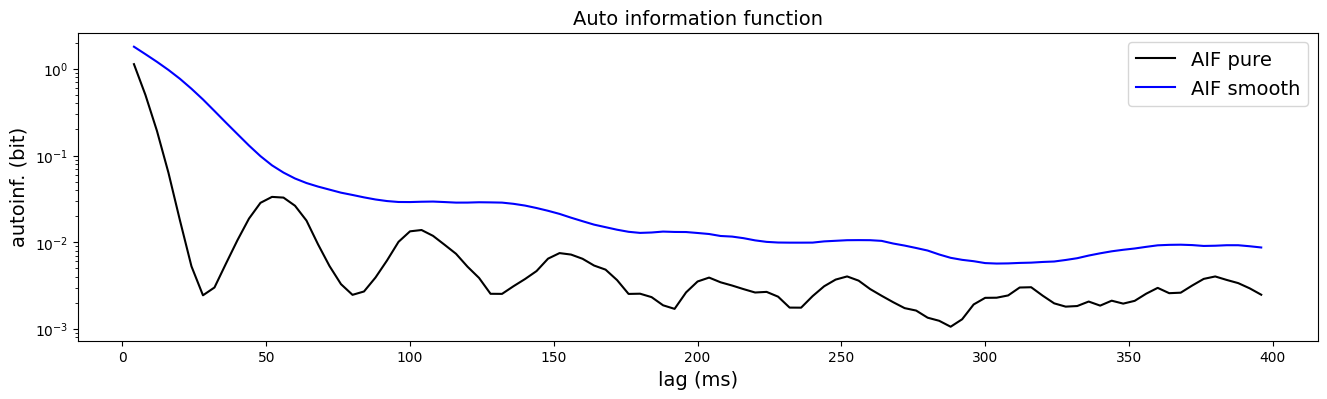

In [49]:
# AIF plot
lags_ms = lags*1000/raw.info['sfreq'] # convert samples in milliseconds
fsize = 14 # fontsize

plt.figure(figsize=(16,4))
plt.semilogy(lags_ms, ai_pure, '-k', label='AIF pure')
plt.semilogy(lags_ms, ai_smooth, '-b', label='AIF smooth')
plt.legend(loc='upper right', fontsize=fsize)
plt.xlabel("lag (ms)", fontsize=fsize)
plt.ylabel("autoinf. (bit)", fontsize=fsize)
plt.title("Auto information function", fontsize=fsize)
plt.show()

## Partial autoinformation
Partial autoinformation (PAI) describes the dependence between microstate sequence labels $k$ samples apart, removing the influence of all intermediate labels. The autoinformation function does not account for the effect of intermediate time steps.  
PAI is computationally more expensive and it is recommended to start with a low number of lags (e.g. 5).  
PAI coefficients can identify (first-order) Markov processes as their PAI coefficients are zero for lags $k \ge 2$. 

Below, we compare the PAI coefficients of microstate sequences with and without smoothing.
It is observed that smoothing shifts temporal dependencies from towards the first time lag, i.e. renders the sequences more Markovian.

In [50]:
# partial_auto_information_function
# TODO: explain the partial_auto_information_function and parameters.
from pycrostates.segmentation import partial_auto_information_function
import numpy as np

lags_paif = np.arange(1, 6)
lags2, pai_pure = partial_auto_information_function(segm_pure, 
                                                    lags=lags_paif, 
                                                    ignore_repetitions=False, 
                                                    n_jobs=1)
lags2, pai_smooth = partial_auto_information_function(segm_smooth, 
                                                      lags=lags_paif, 
                                                      ignore_repetitions=False, 
                                                      n_jobs=1)

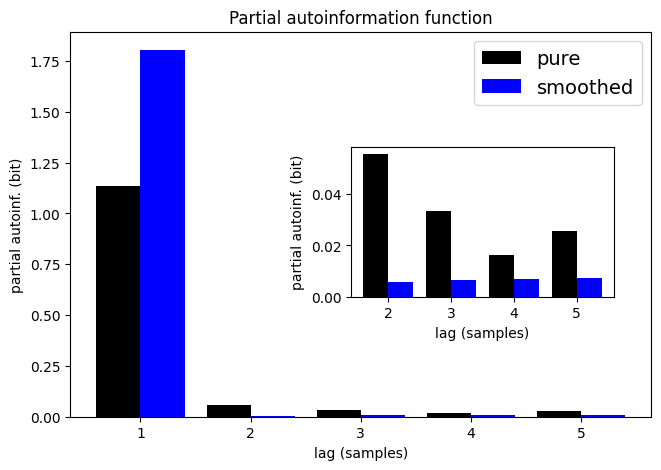

In [52]:
# plot PAIF
w = 0.4
wh = w/2

fig = plt.figure(figsize=(7.5,5))
ax = plt.gca()
ax.bar(lags_paif-wh, pai_pure, width=w, color='k', label='pure')
ax.bar(lags_paif+wh, pai_smooth, width=w, color='b', label='smoothed')
ax.legend(loc='upper right', fontsize=14)
ax.set_xlabel("lag (samples)")
ax.set_ylabel("partial autoinf. (bit)")

offset = 1
left, bottom, width, height = [0.5, 0.35, 0.35, 0.3]
axin = fig.add_axes([left, bottom, width, height])
axin.bar(lags_paif[offset:]-wh, pai_pure[offset:], color='k', width=w)
axin.bar(lags_paif[offset:]+wh, pai_smooth[offset:], color='b', width=w)
axin.set_xlabel("lag (samples)")
axin.set_ylabel("partial autoinf. (bit)")

ax.set_title("Partial autoinformation function")
plt.show()